In [1]:
import numpy as np
import h5py
from tqdm.auto import tqdm
from dataclasses import dataclass

import matplotlib.pyplot as plt
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature


/opt/homebrew/anaconda3/envs/research/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = "/Volumes/SSD/mark/Documents/Works/MT_Dataset/mt_filtered_20250714.h5"

if "ds" in vars():
    ds.close()   # type: ignore

ds = h5py.File(dataset_path, "r")
for attr in ds.attrs:
    print(f"{attr}: {ds.attrs[attr]}")

author: Mark Vodyanitskiy (mvodya@icloud.com)
created_at: 2025-07-13T14:26:08.378871
filter_rules: MIN_TOTAL_POINTS=50, MIN_MOVING_POINTS=5, MIN_MAX_SPEED=20, SPEED_MOVING_MIN=10, SPEED_SANITY_MAX=800
filtered_at: 2026-01-08T06:02:47.931391
sources_count: 27555
sources_size: 439.3Gb
version: 1.0


In [27]:
STOP_SPEED_MAX = 10           # <=0.5 kn считаем "стоп" (можно 10 = 1.0 kn)
MIN_STOP_SEC = 20 * 60        # минимальная длительность стопа 20 минут
GAP_BREAK_SEC = 2 * 60 * 60   # разрыв данных: закрываем стоп
DT_CLIP_SEC = 15 * 60         # клип dt чтобы редкие сообщения не рисовали "гигант-стоп"

CHUNK_ROWS = 2_000_000

# область для карты
extent = [130, 145, 41, 49]   # [lon_min, lon_max, lat_min, lat_max]
bins = (600, 600)             # сетка heatmap

print("Params:",
      STOP_SPEED_MAX, MIN_STOP_SEC, GAP_BREAK_SEC, DT_CLIP_SEC, CHUNK_ROWS, extent, bins)

Params: 5 1200 7200 900 2000000 [130, 145, 41, 49] (600, 600)


In [28]:
def iter_day_datasets(ds: h5py.File):
    gpos = ds["positions"]
    for yyyy in sorted(gpos.keys()):
        for mm in sorted(gpos[yyyy].keys()):
            for dd in sorted(gpos[yyyy][mm].keys()):
                d = gpos[yyyy][mm][dd]
                if isinstance(d, h5py.Dataset):
                    yield (yyyy, mm, dd), d

for k, day_ds in list(iter_day_datasets(ds))[:3]:
    print(k, "rows:", day_ds.shape[0], "dtype fields:", list(day_ds.dtype.fields.keys())[:5], "...")


('2024', '10', '29') rows: 2096349 dtype fields: ['ship_id', 'timestamp', 'lat', 'lon', 'speed'] ...
('2024', '10', '30') rows: 3445896 dtype fields: ['ship_id', 'timestamp', 'lat', 'lon', 'speed'] ...
('2024', '10', '31') rows: 2843489 dtype fields: ['ship_id', 'timestamp', 'lat', 'lon', 'speed'] ...


In [29]:
def build_ship_index(ds: h5py.File):
    ships_ds = ds["ships"]
    ship_ids = ships_ds["ship_id"].astype(np.int64, copy=False)

    # dict ship_id -> idx (для быстрого маппинга из positions в state arrays)
    ship_to_idx = {int(sid): i for i, sid in enumerate(ship_ids)}
    return ship_ids, ship_to_idx

ship_ids, ship_to_idx = build_ship_index(ds)
print("Ships:", ship_ids.size, "example ship_id:", int(ship_ids[0]))
print("Lookup example:", ship_to_idx.get(int(ship_ids[0])))


Ships: 372403 example ship_id: 1
Lookup example: 0


In [ ]:
@dataclass
class StopAgg:
    dur: int
    lat_sum: float
    lon_sum: float
    cnt: int

def compute_stop_heatmap_one_pass(
    ds: h5py.File,
    ship_to_idx: dict[int, int],
    extent,
    bins=(600, 600),
    chunk_rows=2_000_000,
    stop_speed_max=5,
    min_stop_sec=1200,
    gap_break_sec=7200,
    dt_clip_sec=900,
):
    lon_min, lon_max, lat_min, lat_max = extent
    nx, ny = bins

    H = np.zeros((nx, ny), dtype=np.float64)

    N = len(ship_to_idx)
    last_ts = np.full(N, -1, dtype=np.int32)
    in_stop = np.zeros(N, dtype=np.bool_)
    dur = np.zeros(N, dtype=np.int32)
    lat_sum = np.zeros(N, dtype=np.float64)
    lon_sum = np.zeros(N, dtype=np.float64)
    cnt = np.zeros(N, dtype=np.int32)

    def emit(i: int):
        """Закрыть стоп судна i и добавить вклад в heatmap (если проходит порог)."""
        d = int(dur[i])
        c = int(cnt[i])
        if d >= min_stop_sec and c > 0:
            lat = float(lat_sum[i] / c)
            lon = float(lon_sum[i] / c)

            # bin index
            xi = int((lon - lon_min) / (lon_max - lon_min) * nx)
            yi = int((lat - lat_min) / (lat_max - lat_min) * ny)
            if 0 <= xi < nx and 0 <= yi < ny:
                H[xi, yi] += d  # вес = длительность стопа

        # reset stop state
        in_stop[i] = False
        dur[i] = 0
        lat_sum[i] = 0.0
        lon_sum[i] = 0.0
        cnt[i] = 0

    # Посчитаем total rows для tqdm
    total_rows = 0
    days = []
    for k, day_ds in iter_day_datasets(ds):
        days.append((k, day_ds))
        total_rows += int(day_ds.shape[0])

    from tqdm.auto import tqdm
    p = tqdm(total=total_rows, desc="One-pass stop heatmap", unit="rows")

    for (yyyy, mm, dd), day_ds in days:
        n = int(day_ds.shape[0])

        # Прогресс по дням
        p.set_postfix_str(f"{yyyy}-{mm}-{dd}")

        for start in range(0, n, chunk_rows):
            end = min(n, start + chunk_rows)
            chunk = day_ds[start:end]

            ship = chunk["ship_id"].astype(np.int64, copy=False)
            ts = chunk["timestamp"].astype(np.int32, copy=False)
            sp = chunk["speed"].astype(np.int32, copy=False)       # десятые узла
            la = chunk["lat"].astype(np.float32, copy=False)
            lo = chunk["lon"].astype(np.float32, copy=False)

            # Обрабатываем последовательно (в порядке данных, который у тебя строго по времени)
            # Маппинг ship_id -> idx через dict (быстро и просто)
            for sid, t, s, latv, lonv in zip(ship, ts, sp, la, lo):
                i = ship_to_idx.get(int(sid), -1)
                if i < 0:
                    continue

                prev = int(last_ts[i])
                if prev >= 0:
                    dt = int(t) - prev

                    if dt <= 0:
                        # timestamp назад (не должно быть, но на всякий)
                        last_ts[i] = t
                        continue

                    if dt > gap_break_sec:
                        # Разрыв данных: закрываем стоп если был
                        if in_stop[i]:
                            emit(i)
                        last_ts[i] = t
                        dt = 0  # текущая точка не накапливает длительность от прошлой

                    else:
                        if dt > dt_clip_sec:
                            dt = dt_clip_sec
                        last_ts[i] = t
                else:
                    # Первая точка судна
                    dt = 0
                    last_ts[i] = t

                is_stop = int(s) <= stop_speed_max

                if is_stop:
                    if not in_stop[i]:
                        in_stop[i] = True
                        dur[i] = 0
                        lat_sum[i] = 0.0
                        lon_sum[i] = 0.0
                        cnt[i] = 0

                    dur[i] += dt
                    lat_sum[i] += float(latv)
                    lon_sum[i] += float(lonv)
                    cnt[i] += 1
                else:
                    if in_stop[i]:
                        emit(i)

            p.update(end - start)

    p.close()

    # Закрываем хвостовые стопы
    for i in range(N):
        if in_stop[i]:
            emit(i)

    return H

In [32]:
def compute_stop_heatmap_one_pass_first_k_days(ds, ship_to_idx, extent, k_days=3, **kwargs):
    # Временно переопределим итератор дней (замкнемся)
    all_days = list(iter_day_datasets(ds))
    sub = all_days[:k_days]

    # Локальная копия iter_day_datasets для функции ниже не нужна - просто сделаем "мини ds" через список
    # поэтому сделаем легкий клон функции, где days = sub:
    lon_min, lon_max, lat_min, lat_max = extent
    nx, ny = kwargs.get("bins", (600, 600))
    H = np.zeros((nx, ny), dtype=np.float64)

    N = len(ship_to_idx)
    last_ts = np.full(N, -1, dtype=np.int32)
    in_stop = np.zeros(N, dtype=np.bool_)
    dur = np.zeros(N, dtype=np.int32)
    lat_sum = np.zeros(N, dtype=np.float64)
    lon_sum = np.zeros(N, dtype=np.float64)
    cnt = np.zeros(N, dtype=np.int32)

    stop_speed_max = kwargs.get("stop_speed_max", 5)
    min_stop_sec = kwargs.get("min_stop_sec", 1200)
    gap_break_sec = kwargs.get("gap_break_sec", 7200)
    dt_clip_sec = kwargs.get("dt_clip_sec", 900)
    chunk_rows = kwargs.get("chunk_rows", 2_000_000)

    def emit(i: int):
        d = int(dur[i])
        c = int(cnt[i])
        if d >= min_stop_sec and c > 0:
            lat = float(lat_sum[i] / c)
            lon = float(lon_sum[i] / c)
            xi = int((lon - lon_min) / (lon_max - lon_min) * nx)
            yi = int((lat - lat_min) / (lat_max - lat_min) * ny)
            if 0 <= xi < nx and 0 <= yi < ny:
                H[xi, yi] += d
        in_stop[i] = False
        dur[i] = 0
        lat_sum[i] = 0.0
        lon_sum[i] = 0.0
        cnt[i] = 0

    total_rows = sum(int(day_ds.shape[0]) for _, day_ds in sub)
    from tqdm.auto import tqdm
    p = tqdm(total=total_rows, desc=f"TEST one-pass (first {k_days} days)", unit="rows")

    for (yyyy, mm, dd), day_ds in sub:
        p.set_postfix_str(f"{yyyy}-{mm}-{dd}")
        n = int(day_ds.shape[0])

        for start in range(0, n, chunk_rows):
            end = min(n, start + chunk_rows)
            chunk = day_ds[start:end]

            ship = chunk["ship_id"].astype(np.int64, copy=False)
            ts = chunk["timestamp"].astype(np.int32, copy=False)
            sp = chunk["speed"].astype(np.int32, copy=False)
            la = chunk["lat"].astype(np.float32, copy=False)
            lo = chunk["lon"].astype(np.float32, copy=False)

            for sid, t, s, latv, lonv in zip(ship, ts, sp, la, lo):
                i = ship_to_idx.get(int(sid), -1)
                if i < 0:
                    continue

                prev = int(last_ts[i])
                if prev >= 0:
                    dt = int(t) - prev
                    if dt <= 0:
                        last_ts[i] = t
                        continue
                    if dt > gap_break_sec:
                        if in_stop[i]:
                            emit(i)
                        last_ts[i] = t
                        dt = 0
                    else:
                        if dt > dt_clip_sec:
                            dt = dt_clip_sec
                        last_ts[i] = t
                else:
                    dt = 0
                    last_ts[i] = t

                is_stop = int(s) <= stop_speed_max
                if is_stop:
                    if not in_stop[i]:
                        in_stop[i] = True
                        dur[i] = 0
                        lat_sum[i] = 0.0
                        lon_sum[i] = 0.0
                        cnt[i] = 0

                    dur[i] += dt
                    lat_sum[i] += float(latv)
                    lon_sum[i] += float(lonv)
                    cnt[i] += 1
                else:
                    if in_stop[i]:
                        emit(i)

            p.update(end - start)

    p.close()
    for i in range(N):
        if in_stop[i]:
            emit(i)

    return H

H_test = compute_stop_heatmap_one_pass_first_k_days(
    ds, ship_to_idx, extent,
    k_days=3,
    bins=bins,
    chunk_rows=CHUNK_ROWS,
    stop_speed_max=STOP_SPEED_MAX,
    min_stop_sec=MIN_STOP_SEC,
    gap_break_sec=GAP_BREAK_SEC,
    dt_clip_sec=DT_CLIP_SEC,
)

print("H_test nonzero cells:", int(np.sum(H_test > 0)))


TEST one-pass (first 3 days): 100%|██████████| 8385734/8385734 [00:11<00:00, 735229.01rows/s, 2024-10-31]

H_test nonzero cells: 544


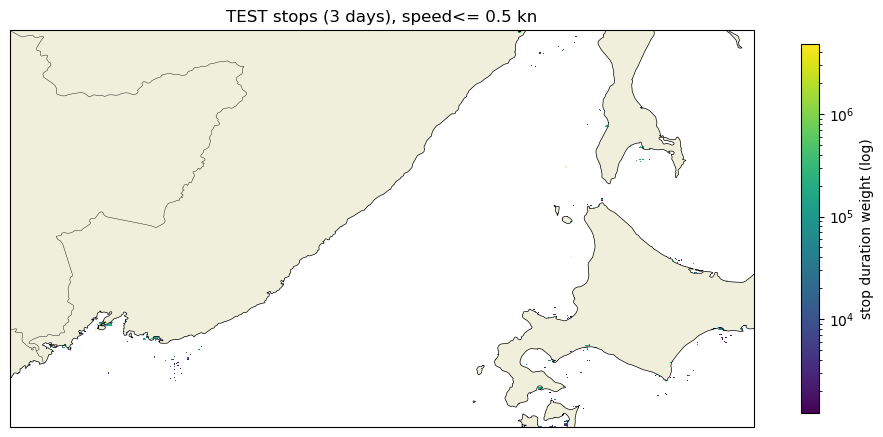

In [40]:
def plot_heatmap(H, extent, title="Stop heatmap"):
    lon_min, lon_max, lat_min, lat_max = extent
    proj = ccrs.PlateCarree()

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_extent(extent, crs=proj)

    ax.add_feature(cfeature.LAND, linewidth=0.2)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)

    nz = H[H > 0]
    norm = None
    if nz.size:
        norm = mpl.colors.LogNorm(vmin=float(nz.min()), vmax=float(nz.max()))

    im = ax.imshow(
        H.T,
        origin="lower",
        extent=[lon_min, lon_max, lat_min, lat_max],
        transform=proj,
        interpolation="nearest",
        norm=norm,
    )
    ax.set_title(title)
    cb = fig.colorbar(im, ax=ax, orientation="vertical", shrink=0.6)
    cb.set_label("stop duration weight (log)" if norm else "stop duration weight")

    plt.show()

# ---- test plot ----
plot_heatmap(H_test, extent, title=f"TEST stops (3 days), speed<= {STOP_SPEED_MAX/10:.1f} kn")

In [ ]:
H = compute_stop_heatmap_one_pass(
    ds,
    ship_to_idx=ship_to_idx,
    extent=extent,
    bins=bins,
    chunk_rows=CHUNK_ROWS,
    stop_speed_max=STOP_SPEED_MAX,
    min_stop_sec=MIN_STOP_SEC,
    gap_break_sec=GAP_BREAK_SEC,
    dt_clip_sec=DT_CLIP_SEC,
)

print("nonzero cells:", int(np.sum(H > 0)))


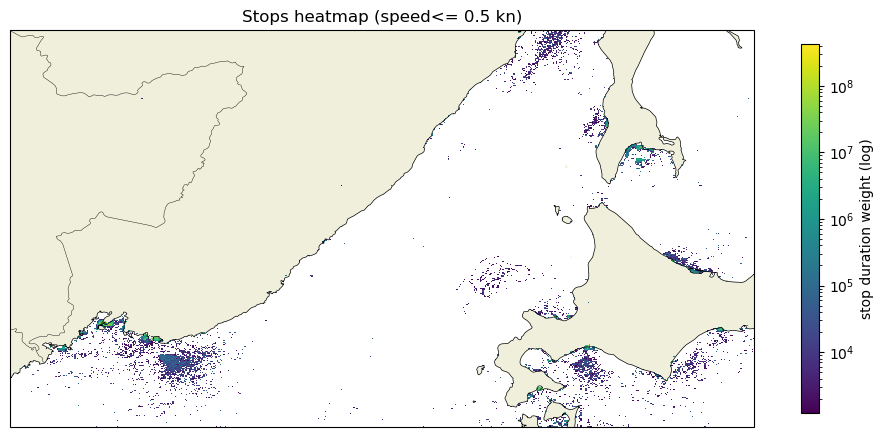

In [41]:
plot_heatmap(H, extent, title=f"Stops heatmap (speed<= {STOP_SPEED_MAX/10:.1f} kn)")